<a href="https://colab.research.google.com/github/kyj098707/I_HATE_HATE/blob/main/KoBERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***I_HATE_HATE : KoBERT를 활용한 나쁜 말 탐지기***

In [1]:
#### kobert 다운로드
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-pcie986f/kobert-tokenizer_739c1869812340dbad413b4e6a7cdab6
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-pcie986f/kobert-tokenizer_739c1869812340dbad413b4e6a7cdab6
  Created wheel for kobert-tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4649 sha256=3060560203ee3f15bd3c44c70cdfeef288a3b9237af3bb27287c6fa795fe980a
  Stored in directory: /tmp/pip-ephem-wheel-cache-06eoa9et/wheels/10/b4/d9/cb627bbfaefa266657b0b4e8127f7bf96d27376fa1a23897b4
Successfully built kobert-tokenizer


In [2]:
### requirements
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 5.2 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595736 sha256=0b31ae0c84cde071431a407c9b00301f76a9bc81ad4497f3b9b5ce32deca96a1
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

In [3]:
#### dataset은 smile gate에서 제공한 dataset을 사용하였습니다.
!git clone https://github.com/smilegate-ai/korean_unsmile_dataset.git

Cloning into 'korean_unsmile_dataset'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 1.35 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [4]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [5]:
train_data = pd.read_csv("/content/korean_unsmile_dataset/unsmile_train_v1.0.tsv",sep='\t')
vaild_data = pd.read_csv("/content/korean_unsmile_dataset/unsmile_valid_v1.0.tsv",sep='\t') 

In [6]:
train_data

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0,0,0,0,0,0,0,0,0,1,0
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15000,께롱께롱께롱!!!,0,0,0,0,0,0,0,0,0,1,0
15001,갱상도가아니라 홍어지 개좃같은 홍어년들,0,0,0,0,0,1,0,0,0,0,0
15002,말레이시아랑 인도네시아 여자 존나 못생겼던데,1,0,0,1,0,0,0,0,0,0,0
15003,링크도 안박고 가서 글 쓰자고 선동하네,0,0,0,0,0,0,0,0,1,0,0


In [7]:
LABEL_COLUMNS = train_data.columns.tolist()[1:]
LABEL_COLUMNS

['여성/가족',
 '남성',
 '성소수자',
 '인종/국적',
 '연령',
 '지역',
 '종교',
 '기타 혐오',
 '악플/욕설',
 'clean',
 '개인지칭']

In [8]:
from kobert_tokenizer import KoBERTTokenizer

In [9]:
MODEL_NAME = 'skt/kobert-base-v1'
tokenizer = KoBERTTokenizer.from_pretrained(MODEL_NAME)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [10]:
sample_sentence = train_data.iloc[17]
sample_comment = sample_sentence['문장']
sample_labels = sample_sentence[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

위로와 격려를 호텔에서 해? 왜? 저여자도 정상은 아니구만 완전 지네 할아버지보다 나이가 더 많을듯한데 토나올꺼같은데.. 둘다 미쳤구만.. 그렇게 더러운짓은 하고 설교를 어떻게 하는거야.. 웩!

{'여성/가족': 0, '남성': 0, '성소수자': 0, '인종/국적': 0, '연령': 0, '지역': 0, '종교': 0, '기타 혐오': 0, '악플/욕설': 1, 'clean': 0, '개인지칭': 0}


In [11]:
sample_sentence

문장       위로와 격려를 호텔에서 해? 왜? 저여자도 정상은 아니구만 완전 지네 할아버지보다 ...
여성/가족                                                    0
남성                                                       0
성소수자                                                     0
인종/국적                                                    0
연령                                                       0
지역                                                       0
종교                                                       0
기타 혐오                                                    0
악플/욕설                                                    1
clean                                                    0
개인지칭                                                     0
Name: 17, dtype: object

In [12]:
from torch.utils.data import Dataset, DataLoader
import torch

class HateCommentDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer : KoBERTTokenizer,
        max_token_len: int = 128
    ):

        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]

        comment_text = data_row['문장']
        labels = data_row[LABEL_COLUMNS]
        
        ### 해당 부분 공부
        encoding = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return dict(
            comment_text = comment_text,
            input_ids = encoding["input_ids"].flatten(),
            attention_mask = encoding["attention_mask"].flatten(),
            labels = torch.FloatTensor(labels)
        )

In [13]:
MAX_TOKEN_COUNT = 512

train_dataset = HateCommentDataset(
    train_data,
    tokenizer,
    max_token_len = MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [14]:
print(sample_item["comment_text"])
print(sample_item["input_ids"])
print(sample_item["labels"])

일안하는 시간은 쉬고싶어서 그런게 아닐까
tensor([   2, 3803, 6812, 7794, 2962, 7086, 2923, 5439, 6751, 6855, 6553, 1201,
        5400, 3093, 5777, 5591,    3,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    

In [15]:
###KoBERT모델 불러오기
from transformers import BertModel

bert_model = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=True)

In [16]:
### torch dataloader
from torch.utils.data import DataLoader

sample_batch = next(iter(DataLoader(train_dataset, batch_size= 8,num_workers =2 )))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [17]:
output = bert_model(sample_batch["input_ids"],sample_batch["attention_mask"])

In [18]:
output

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[ 0.0502,  0.1253, -0.0378,  ...,  0.1481,  0.2696,  0.1062],
                                                        [-0.4339, -0.2887, -0.3679,  ...,  0.0367,  0.3098,  0.1862],
                                                        [ 0.3185,  0.1451, -0.1537,  ...,  0.2951,  0.0335, -0.3593],
                                                        ...,
                                                        [ 0.1908, -0.5487,  0.2235,  ..., -0.6116, -0.1582, -0.1056],
                                                        [ 0.1908, -0.5487,  0.2235,  ..., -0.6116, -0.1582, -0.1056],
                                                        [ 0.1908, -0.5487,  0.2235,  ..., -0.6116, -0.1582, -0.1056]],
                                               
                                                       [[-0.4716,  0.0419,  0.1233,  ...,  0.0985,  0.2793,  0.058

In [19]:
bert_model.config.hidden_size

768

In [20]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 701 kB 5.0 MB/s 
     |████████████████████████████████| 5.8 MB 44.2 MB/s 
     |████████████████████████████████| 419 kB 61.1 MB/s 
     |████████████████████████████████| 141 kB 58.5 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.9.1 which is incompatible.


In [21]:
### lightning.metrics --> torchmetrics로 변경

import pytorch_lightning as pl
from torchmetrics.functional import accuracy,f1_score,auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [22]:
class HateCommentDataModule(pl.LightningDataModule):

    def __init__(self, train_df, test_df, tokenizer, batch_size = 8, max_token_len = 128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage = None):
        self.train_dataset = HateCommentDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = HateCommentDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 2
        )

    def val_dataloader(self):
        return DataLoader(
            self.batch_size,
            batch_size = self.batch_size,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            num_workers = 2
        )

In [23]:
N_EPOCHS = 5
BATCH_SIZE = 12

data_module = HateCommentDataModule(
    train_data,
    vaild_data,
    tokenizer,
    batch_size = BATCH_SIZE,
    max_token_len = MAX_TOKEN_COUNT
)

In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn as nn

class HateCommentTagger(pl.LightningModule):

    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps= None):
        super().__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels= None):
        output = self.bert(input_ids, attention_mask = attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss,outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar =True, logger = True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss,outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar =True, logger = True)
        return loss

    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)

        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:,i],labels[:,i])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr= 2e-5)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps= self.n_warmup_steps,
            num_training_steps = self.n_training_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler = dict(
            scheduler = scheduler,
            interval='step'
        )
    )
    

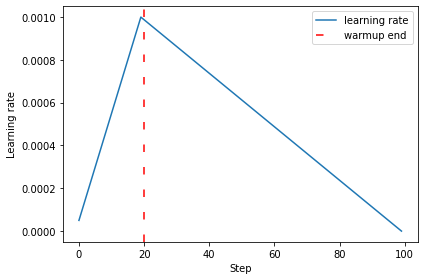

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

dummy_model = nn.Linear(2,1)

optimizer = AdamW(params=dummy_model.parameters(),lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = warmup_steps,
    num_training_steps = total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])

plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [26]:
steps_per_epoch = len(train_data)
total_training_steps = steps_per_epoch * N_EPOCHS 

In [27]:
warmup_steps = total_training_steps//5
warmup_steps, total_training_steps

(15005, 75025)

In [28]:
model = HateCommentTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps = warmup_steps,
    n_training_steps = total_training_steps
)

In [29]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
    [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)

labels = torch.FloatTensor(
    [1. ,0. ,0. ,0. ,1. ,0. ]
)

In [30]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [31]:
criterion(torch.sigmoid(prediction),labels)

tensor(0.8725)

In [32]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5518, 0.4852, 0.3933, 0.5748, 0.4362, 0.4404, 0.5049, 0.4685, 0.5945,
         0.4888, 0.3845],
        [0.5720, 0.4527, 0.6557, 0.5718, 0.5135, 0.5124, 0.5937, 0.4741, 0.4488,
         0.5136, 0.6753],
        [0.6219, 0.4433, 0.6132, 0.5926, 0.5000, 0.5163, 0.5807, 0.4888, 0.5438,
         0.5496, 0.6231],
        [0.6062, 0.4207, 0.6382, 0.5911, 0.5059, 0.5006, 0.5797, 0.4752, 0.4866,
         0.5307, 0.6385],
        [0.6321, 0.4436, 0.5964, 0.5666, 0.5140, 0.5095, 0.5814, 0.4885, 0.5353,
         0.5263, 0.6117],
        [0.5382, 0.5169, 0.4375, 0.5146, 0.4406, 0.4374, 0.4623, 0.4839, 0.5338,
         0.4371, 0.4681],
        [0.6058, 0.4485, 0.5328, 0.5807, 0.4556, 0.4905, 0.5399, 0.5094, 0.5968,
         0.4836, 0.5223],
        [0.6223, 0.4518, 0.6198, 0.5732, 0.4982, 0.5240, 0.5713, 0.5094, 0.5299,
         0.5359, 0.6246]], grad_fn=<SigmoidBackward0>)

In [33]:
criterion(predictions, sample_batch["labels"])

tensor(0.7428, grad_fn=<BinaryCrossEntropyBackward0>)

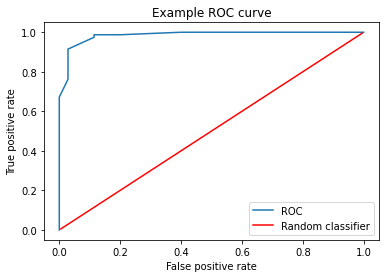

In [34]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]
_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

In [35]:
### 체크포인트 생성
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [36]:
logger = TensorBoardLogger("lightning_logs", name="hate-comments")

In [37]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [38]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[checkpoint_callback, early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [39]:
trainer.fit(model, data_module)

Missing logger folder: lightning_logs/hate-comments
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 92.2 M
1 | classifier | Linear    | 8.5 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
92.2 M    Trainable params
0         Non-trainable params
92.2 M    Total params
368.781   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 1251: 'val_loss' reached 0.36697 (best 0.36697), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1
Epoch 1, global step 2502: 'val_loss' reached 0.24645 (best 0.24645), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1
Epoch 2, global step 3753: 'val_loss' was not in top 1
Epoch 3, global step 5004: 'val_loss' reached 0.19641 (best 0.19641), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1
Epoch 4, global step 6255: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


In [45]:
trained_model = HateCommentTagger.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_classes=len(LABEL_COLUMNS)
)

trained_model.eval()
trained_model.freeze()

test_comment = ""

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

여성/가족: 0.21384520828723907
남성: 0.06210934370756149
성소수자: 0.029444986954331398
인종/국적: 0.02834153175354004
연령: 0.02259404957294464
지역: 0.027536967769265175
종교: 0.015903810039162636
기타 혐오: 0.022705405950546265
악플/욕설: 0.173410102725029
clean: 0.23548029363155365
개인지칭: 0.015115111134946346
